# Algorithmic Strategy 

In [2]:
import yfinance as yf

import os
os.chdir('C:\\Users\\btindol\\OneDrive - Stryker\\Linked In Learn\\Algorithmic Investing\Algorithmic Trading & Quantitative Analysis using Python')  
print(os.getcwd())  # Prints the current working directory

#####################################################################################################################################################
#imports 
#!pip install yfinance 
#!pip install pandas 
#!pip install numpy
#!pip install requests
!pip install datetime
#!pip install yahoofinancials
!pip install stocktrends
from yahoofinancials import YahooFinancials

import pandas as pd
import numpy as np
import requests
import datetime as dt
import os
import json 
from functools import reduce
import statsmodels.api as sm
from stocktrends import Renko
import random

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\btindol\OneDrive - Stryker\Linked In Learn\Algorithmic Investing\Algorithmic Trading & Quantitative Analysis using Python


You should consider upgrading via the 'c:\users\btindol\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\btindol\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
# for each of the column names for the % change columns  Shift the percent change column up one for calculation 
def shifted_column(df):
    pctchg = [col for col in df.columns if 'percent_change' in col] # grabe % change columns
    colnew = []                                                                    # initiate empty list
    for i in range(0,len(pctchg)):                                                 # loop over column names
        print(pctchg[i])
        var1 = df[pctchg[i]].shift(-1)                                            # grab colunmn by name and shift up one
        colnew.append(var1)                                                        # append to list
    colnew = pd.DataFrame(colnew)                                                  # now its wide dataframe
    colnew = colnew.transpose()                                                    # make it narrow
    cols = colnew.columns.tolist()                                                 # take column names of narrow dataframe                                                
    newcols = []                                                                   # make list to add the text shift to the column name
    for j in range(0,len(cols)): 
        colz = cols[j] + "_" + "shift"                                             # add shift to the name of shifted column

        newcols.append(colz) 
    colnew.columns = newcols  
    return colnew\

##################################################################################################################################################################################
##################################################################################################################################################################################
    
# This just cleanse up the column names 
def clean_up_zeros_and_column_names(df):
    df =df.fillna(0)     
    df.columns = df.columns.str.replace("-", "_") 
    return df

##################################################################################################################################################################################
##################################################################################################################################################################################

# gets the percent change of the whole data frame columns and adds the percent change to the column name     
def get_daily_returns(df):
    daily_return = df.pct_change()                    # Get percent change for whole df
    cols = daily_return.columns.tolist()              # makes column names to list
    newcols = []
    for j in range(0,len(cols)):         
        if cols[j] == "formatted_date":               # if column is formated date keep it as such 
            colz = cols[j]
        else:
            colz = cols[j] + "_" + "percent_change"    # else add percent change to name 

        newcols.append(colz)
    daily_return.columns = newcols               
    return daily_return

##################################################################################################################################################################################
##################################################################################################################################################################################

# Get current position of the adusted column if the columns name is shift times the position by return and add position do this for all rows
def get_current_position(df,initial_position):
    
    # Calculate returns from initial position entry 
    shiftval = [col for col in df.columns if 'shift' in col]                   # find the shift column to bring % change up to today to mutliply to get positions next day amount.. 

    initial_position = initial_position                                             # pass from function above

    new = [(df[shiftval[0]][0] * initial_position) + initial_position]        # get first value in final for iterate the 0 of this 
    for i in range(1, len(df.index)):                                          # starting at second row of the dataframe column 
        new.append((new[i-1]*df[shiftval].values[i][0]) +new[i-1])
    
    df['Position'] = new
    df['Position'] = df['Position'].shift(1)
    df['Position'][0] = initial_position
    df.fillna(0)
    return df#['Position']

##################################################################################################################################################################################
##################################################################################################################################################################################

# Calculating RSI without using loop
def rsi(df, n):
    "function to calculate RSI"
    delta = df["Adj Close"].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    return 100 - 100 / (1+rs)

##################################################################################################################################################################################
##################################################################################################################################################################################

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    df2.dropna(inplace=True)
    return df2

##################################################################################################################################################################################
##################################################################################################################################################################################

def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']


##################################################################################################################################################################################
##################################################################################################################################################################################

def slope(ser,n):
    "function to calculate the slope of regression line for n consecutive points on a plot"
    ser = (ser - ser.min())/(ser.max() - ser.min())
    x = np.array(range(len(ser)))
    x = (x - x.min())/(x.max() - x.min())
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y_scaled = ser[i-n:i]
        x_scaled = x[:n]
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

##################################################################################################################################################################################
##################################################################################################################################################################################

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']


# Come back to do renko later!!!!!!

# Get random indexes to inject code at random parts of the loop
def get_random_list_of_indexes(df):
    additional = df[df['positions'] == 1.0].sum().positions # get the sum of positions and minus the first for the entry amount.. 
    additional= (additional-1).astype(int) # minus 1 becuase when comparing when you initialize at first cross over you dont add additional to first 

    #additional_amount = 1000
     # Make random list of certain amount of variables as many as there are buys
    randomlist = []
    for i in range(0,additional):
        n = random.randint(1,1732)
        randomlist.append(n)
    randomlist.sort()
    return randomlist

##################################################################################################################################################################################
##################################################################################################################################################################################
# using the random indexes add additional capital incrementially 

def additional_amount_column(df,randomlist,additional_amount,initial_amount):
    for i in range(0,len(randomlist)):
        newindex = randomlist[i]
        df.loc[df.index[newindex], 'additional_contribution'] = additional_amount

    df['additional_contribution'][0] = initial_amount
    df['additional_contribution']  =df['additional_contribution'].fillna(0)  
    df.additional_contribution.count()
    return df

##################################################################################################################################################################################
##################################################################################################################################################################################
# Mkke colunmn that gets the value of current position for the additional contribution strategy.. 
def buy_beginning_randomly_contribute_same_number_of_times_as_strategy(df):
    initial_position = df['additional_contribution'][0]
    new = [(df.percent_change_shift.values[0] * initial_position) + initial_position]
    for i in range(1, len(df.index)): # starting at second row of the dataframe column 
         new.append((new[i-1]*df.percent_change_shift.values[i]) + new[i-1] +df.additional_contribution.values[i])# take new and multiply the first calculated value by the next percent change plus the origional value to get new position value
    df['buy_at_begin_and_random_contribute'] = new
    return df

##################################################################################################################################################################################
##################################################################################################################################################################################
# Use this to split up df for strategy implementatinon if counter is 0 meaning there isnt signal yet then 0 else add 1 to counter to count rows starting from when signal starts 
def counter_column(df):
    newft = []
    counter = 0
    for i in range(0, len(df.index)):
        if df.signal.values[i] == 0 and counter == 0:
            newft.append(0)
        else:
            counter +=1
            newft.append(counter)
    return  newft  

##################################################################################################################################################################################
##################################################################################################################################################################################
def buy_at_beginning_and_hold(CrossOver_Strat,initial_position):
    initial_position = initial_position
    new = [(CrossOver_Strat.percent_change_shift.values[0] * initial_position) + initial_position] # make the first value of new column hold it in variable where we take initial position and multiply by the shifted percent change column to get initial starting value
    for i in range(1, len(CrossOver_Strat.index)): # starting at second row of the dataframe column 
        new.append((new[i-1]*CrossOver_Strat.percent_change_shift.values[i]) +new[i-1]) # take new and multiply the first calculated value by the next percent change plus the origional value to get new position value

    # Assign the list new to the dataframe column
    CrossOver_Strat['Buy_at_Begining_and_Hold_Position'] = new
    CrossOver_Strat['Buy_at_Begining_and_Hold_Position'] = CrossOver_Strat['Buy_at_Begining_and_Hold_Position'].round(2).shift(1) # shift it down to make since since shifted percent change up one value
    CrossOver_Strat.Buy_at_Begining_and_Hold_Position.iloc[0] = initial_position  # inject the initial starting amount into the first value of the column.. 
    return CrossOver_Strat


##################################################################################################################################################################################
##################################################################################################################################################################################
def sma_strategy_signal_creator(df,short_window,long_window):
    short_window= 30
    long_window = 90
    final_f = df.copy()

    CrossOver_Strat = final_f#[["Adj Close"]]

    # Short and long moving average.. 
    CrossOver_Strat["short_mavg"] = CrossOver_Strat["Adj Close"].rolling(window= short_window,min_periods=1, center=False).mean()
    CrossOver_Strat["long_mavg"] = CrossOver_Strat["Adj Close"].rolling(window= long_window,min_periods=1, center=False).mean()

    CrossOver_Strat["signal"]=0
    CrossOver_Strat["signal"][short_window:] =np.where(CrossOver_Strat['short_mavg'][short_window:] > CrossOver_Strat['long_mavg'][short_window:],1,0)

    CrossOver_Strat["positions"] = CrossOver_Strat["signal"].diff()
    CrossOver_Strat["positions"] = CrossOver_Strat["positions"].fillna(0)

    CrossOver_Strat['buy_only'] = np.where(CrossOver_Strat['positions'] == 1,1000,0) # buy every day if 1
    CrossOver_Strat['buy_sell'] = np.where(CrossOver_Strat['positions'] == 1,1000,np.where(CrossOver_Strat['positions']==-1,-1000,0)) # buy right when it crosses over.. 

    CrossOver_Strat['percent_change_shift'] = CrossOver_Strat["Adj Close"].pct_change().shift(-1) # get percent change for adj close and shift it up for multiplication.
    CrossOver_Strat["percent_change_shift"] = CrossOver_Strat["percent_change_shift"].fillna(0)
    return CrossOver_Strat


In [4]:
def buy_at_first_position_sell_all_reenter_plus_additional(dff,initial_position,additional_capital_incrementally):
    additional_capital_incrementally = additional_capital_incrementally
    cash_to_spend = []             # this is how much cash you have invested in now
    returnz = []                   # list of returns
    amount_of_cash_put_in =[]      # amount of cash up in 
    
    initial_position = initial_position 
    varzf = dff[dff.positions == 1].first_valid_index()  # find first time the signal goes off get index
    filtered_df = dff.loc[varzf::,]  # bottom half after first signal..  split the dataframe at first time goes off
    length = len(dff.loc[:varzf,])-1 # get the top half of the dataframe where signal is still all 0 and first crossover hasnt happened
    filtered_df2 = dff.iloc[:length,] # split the dataframe at that index. 

    for i in range(0,len(filtered_df)):
        if i == 0: # if it is the first value of dataframe where we filter to the first crossover as the first row
            returnzvar =(initial_position  * filtered_df.iloc[i][7]) + (initial_position) # multiply the price or adjusted value by the % change and add initial position plus price.. (NOt sure if i should do this??? no multiply for first posotiion??)
            returnz.append(returnzvar)

            cash_to_spend.append(0)
            amount_of_cash_put_in.append(initial_position) # append to cashposition list the initial entry position as first value 


        elif filtered_df.positions[i] == 0:
        # Basically then we take the previous value times tjhe return plus previous value
            returnzvar = (returnz[i-1] * filtered_df.iloc[i][7]) + returnz[i-1] # take last returnz value then multiply it 
            returnz.append(returnzvar)

            cash_to_spend.append(cash_to_spend[i-1])
            amount_of_cash_put_in.append(amount_of_cash_put_in[i-1])

        elif filtered_df.positions[i] == -1:
            #returnval = #(returnz[i-1] * -1)# hold for later with cash append 0 because we sold all 
            returnz.append(0)

            cash_to_spend.append(returnz[i-1]) # append the last value of the growing number that you multiply by return.. 
            amount_of_cash_put_in.append(0)

        elif filtered_df.positions[i] == 1: # if its not the first time the cross over happnes (aka) when we put initial position down
            returnz.append(cash_to_spend[i-1] + additional_capital_incrementally) # because from -1 to 1 cash to spend has been the last value of returnsz we grab that value

            cash_to_spend.append(0) # Make cash to spend 0 again because we are buying agiain which means take all cash on hand and put it back into the stock. 
            amount_of_cash_put_in.append(additional_capital_incrementally)

        else:
            continue

    filtered_df['buy_sell_crossover_strat_returnz_added_additional_capital'] = returnz
    final_df = pd.concat([filtered_df2, filtered_df])
    return final_df
    

In [5]:
def buy_at_first_position_sell_all_reenter_no_additional(dff,initial_position,additional_capital_incrementally):
    additional_capital_incrementally = additional_capital_incrementally
    cash_to_spend = []             # this is how much cash you have invested in now
    returnz = []                   # list of returns
    amount_of_cash_put_in =[]      # amount of cash up in 
    
    initial_position = initial_position 
    varzf = dff[dff.positions == 1].first_valid_index()  # find first time the signal goes off get index
    filtered_df = dff.loc[varzf::,]  # bottom half after first signal..  split the dataframe at first time goes off
    length = len(dff.loc[:varzf,])-1 # get the top half of the dataframe where signal is still all 0 and first crossover hasnt happened
    filtered_df2 = dff.iloc[:length,] # split the dataframe at that index. 

    for i in range(0,len(filtered_df)):
        if i == 0: # if it is the first value of dataframe where we filter to the first crossover as the first row
            returnzvar =(initial_position  * filtered_df.iloc[i][7]) + (initial_position) # multiply the price or adjusted value by the % change and add initial position plus price.. (NOt sure if i should do this??? no multiply for first posotiion??)
            returnz.append(returnzvar)

            cash_to_spend.append(0)
            amount_of_cash_put_in.append(initial_position) # append to cashposition list the initial entry position as first value 


        elif filtered_df.positions[i] == 0:
        # Basically then we take the previous value times tjhe return plus previous value
            returnzvar = (returnz[i-1] * filtered_df.iloc[i][7]) + returnz[i-1] # take last returnz value then multiply it 
            returnz.append(returnzvar)

            cash_to_spend.append(cash_to_spend[i-1])
            amount_of_cash_put_in.append(amount_of_cash_put_in[i-1])

        elif filtered_df.positions[i] == -1:
            #returnval = #(returnz[i-1] * -1)# hold for later with cash append 0 because we sold all 
            returnz.append(0)

            cash_to_spend.append(returnz[i-1]) # append the last value of the growing number that you multiply by return.. 
            amount_of_cash_put_in.append(0)

        elif filtered_df.positions[i] == 1: # if its not the first time the cross over happnes (aka) when we put initial position down
            returnz.append(cash_to_spend[i-1]) # because from -1 to 1 cash to spend has been the last value of returnsz we grab that value

            cash_to_spend.append(0) # Make cash to spend 0 again because we are buying agiain which means take all cash on hand and put it back into the stock. 
            amount_of_cash_put_in.append(cash_to_spend[i-1])

        else:
            continue

    filtered_df['buy_sell_crossover_strat_returnz_no_additional_capital'] = returnz
    final_df = pd.concat([filtered_df2, filtered_df])
    return final_df
    
    

In [6]:
def single_stock_analyzer(stocks, begin_date,end_date,initial_position,slow_ma,fast_ma,additional_capital_incrementally):

    # looping over tickers and creating a dataframe with closing prices
    # get just adjusted close column for that ticker
    for ticker in stocks:
        AdjclosePrice = yf.download(ticker,beg_date,end_date)[['Adj Close','Open','High','Low','Close','Volume']]     
    
    # Make it a dataframe
    AdjclosePrice = pd.DataFrame(AdjclosePrice)
    
    # pass dataframe into function that gets the adjusted close percent change column
    AdjclosePrice_PctChg = get_daily_returns(AdjclosePrice)
    
    # merge percent change column to normal price of the stock (Adj Close)
    final = AdjclosePrice.merge(AdjclosePrice_PctChg, on='Date', how='left')
    
    # Shift the percent change column up for multiplying by the initial position input column later to simulate earnings.. 
    colnew =shifted_column(AdjclosePrice_PctChg)

    # join the new column onto existing Adj Close and Adj Close percent change columns 
    final_f= final.merge(colnew, on='Date', how='left')

    # fill na's with 0's and change weird characters such as - to _ in column names 
    final_f = clean_up_zeros_and_column_names(final_f)

    # See how the money you put in performed.. 
    var = get_current_position(final_f,initial_position)
    final_f['Position'] = var
    
    # Get the moving averages for the crossover strategt slow and fast moving averages..  
    final_f['Fast_moving_average'] = final_f['Adj Close'].rolling(window=fast_ma).mean() # 5 day price moving average
    final_f['Slow_moving_average'] = final_f['Adj Close'].rolling(window=slow_ma).mean() # 5 day price moving average

    # Bolligner band of the fast moving average 30 day.. 
    final_f["BB_up"] = final_f["Fast_moving_average"] + 2*final_f['Adj Close'].rolling(fast_ma).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    final_f["BB_dn"] = final_f["Fast_moving_average"] - 2*final_f['Adj Close'].rolling(fast_ma).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    final_f["BB_width"] = final_f["BB_up"] - final_f["BB_dn"]
    
    # rsi standard 14 periods
    final_f["RSI_fast_14_periods"] = rsi(final_f,14) # standard periods is 14
    final_f["RSI_slow_30_periods"] = rsi(final_f,30) # longer than average periods 30 
    
    # Average true range 14 period is standard 
    final_f2 = ATR(final_f,14) # 14 is standard for longer use 20 
    
    # Average directional movement here we will use a period matching the fast moving average
    final_f2['ADX'] = ADX(final_f2,fast_ma)
    
    
    #MACD, short for moving average convergence/divergence    
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    a = 12;b=26;c=9
    final_f2["MA_Fast"]=final_f2["Adj Close"].ewm(span=a,min_periods=a).mean()
    final_f2["MA_Slow"]=final_f2["Adj Close"].ewm(span=b,min_periods=b).mean()
    final_f2["MACD"]=final_f2["MA_Fast"]-final_f2["MA_Slow"]
    final_f2["Signal"]=final_f2["MACD"].ewm(span=c,min_periods=c).mean()
    
    
    # Slope for last 5 days change if needed
    final_f2["close_slope"] = slope(final_f2["Adj Close"],5)
    
    # OBV
    OBV2= OBV(final_f2)
    
    # Merge OBV 
    final_f3 = final_f2.merge(OBV2, on='Date', how='left')
    
    # get signal from simple ma crossover strategy 
    final_f4 = sma_strategy_signal_creator(final_f3,30,90)
    
    # This is for injecting random even spaced amounts of money
    randomlist = get_random_list_of_indexes(final_f4)
    
    # add additional captial incrementally using random indexes from the list 
    final_f5 = additional_amount_column(final_f4,randomlist,additional_capital_incrementally,initial_position)

    # make column where you use the strategy buy at beginning and randomly contribute as many times as sma cross over signal happens
    final_f6 =buy_beginning_randomly_contribute_same_number_of_times_as_strategy(final_f5)

    # add a counter column that starts counting rows when the first signal first shows up
    final_f6['counter'] =counter_column(final_f6)

    # strategy that buys at first signal position then sells all current capital at sell signal then adds all capital back in plus additional amount at next entry.. 
    final_f7 = buy_at_first_position_sell_all_reenter_plus_additional(final_f6,initial_position,additional_capital_incrementally)

    # Buy at beginning and hold strategy.. 
    final_f8 = buy_at_beginning_and_hold(final_f7,initial_position)
    
    # strategy that buys at first signal position then sells all current capital at sell signal then adds all capital back in with no extra additional amount at next entry.. 
    final_f9 = buy_at_first_position_sell_all_reenter_no_additional(final_f8,initial_position,additional_capital_incrementally)

    return final_f9

In [7]:
stocks = ['ETH-USD']
end_date = (dt.date.today()).strftime('%Y-%m-%d')
beg_date = (dt.date.today()-dt.timedelta(1825)).strftime('%Y-%m-%d') # 1825 is 5 years ish 
final_f = single_stock_analyzer(stocks,beg_date,end_date,10.239700,30,90,1000)
final_f

[*********************100%***********************]  1 of 1 completed
Adj Close_percent_change
Open_percent_change
High_percent_change
Low_percent_change
Close_percent_change
Volume_percent_change


,Adj Close,Open,High,Low,Close,Volume,Adj Close_percent_change,Open_percent_change,High_percent_change,Low_percent_change,...,positions,buy_only,buy_sell,percent_change_shift,additional_contribution,buy_at_begin_and_random_contribute,counter,buy_sell_crossover_strat_returnz_added_additional_capital,Buy_at_Begining_and_Hold_Position,buy_sell_crossover_strat_returnz_no_additional_capital
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-30,11.228900,10.992100,11.303600,10.958800,11.228900,7221260,0.022315,0.007054,0.014121,0.015663,...,0.0,0,0,0.039496,10.2397,10.644131,0,NaN,10.2397,NaN
2016-08-31,11.672400,11.238600,11.680200,11.183900,11.672400,11073700,0.039496,0.022425,0.033317,0.020541,...,0.0,0,0,0.027629,0.0000,10.938220,0,NaN,10.6400,NaN
2016-09-01,11.994900,11.670500,12.581500,11.648500,11.994900,24051500,0.027629,0.038430,0.077165,0.041542,...,0.0,0,0,0.009846,0.0000,11.045916,0,NaN,10.9400,NaN
2016-09-02,12.113000,11.964200,12.313300,11.882400,12.113000,9368300,0.009846,0.025166,-0.021317,0.020080,...,0.0,0,0,-0.029250,0.0000,10.722828,0,NaN,11.0500,NaN
2016-09-03,11.758700,12.112900,12.363600,11.347200,11.758700,13358800,-0.029250,0.012429,0.004085,-0.045041,...,0.0,0,0,-0.006701,0.0000,10.650970,0,NaN,10.7200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,2419.906250,2742.468994,2761.363281,2336.361328,2419.906250,39999114805,-0.115689,-0.050639,-0.044098,-0.115888,...,0.0,0,0,-0.058016,0.0000,82697.277541,1699,547352.660982,2206.7300,3991.058618
2021-05-29,2279.514160,2414.067139,2566.938477,2208.490967,2279.514160,33773720220,-0.058016,-0.119747,-0.070409,-0.054731,...,0.0,0,0,0.048603,0.0000,86716.614520,1700,481808.937481,2078.7000,3513.142164
2021-05-30,2390.305420,2278.288818,2472.187744,2188.834473,2390.305420,25876619428,0.048603,-0.056245,-0.036912,-0.008900,...,0.0,0,0,0.135815,0.0000,98494.051909,1701,454709.770604,2179.7300,3315.546773


# Visualize the trading strategy.. 

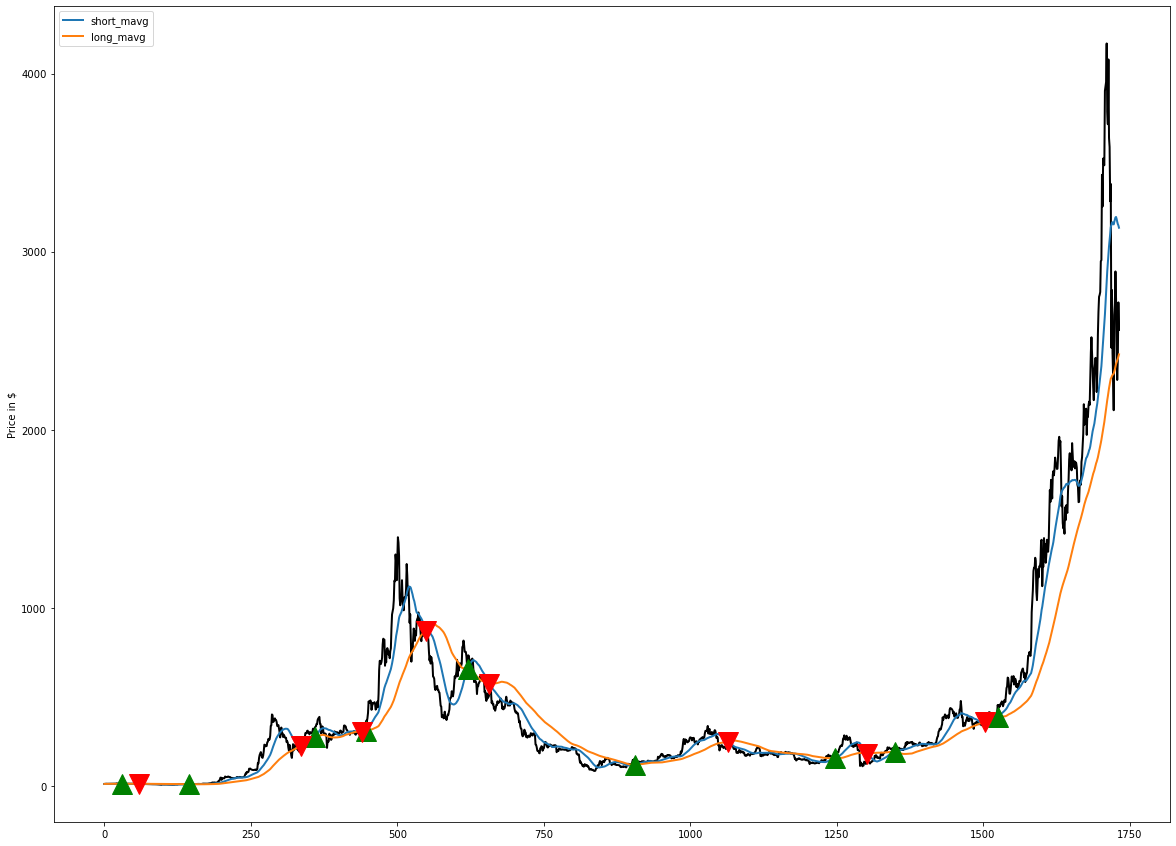

In [8]:
final_f.reset_index(inplace=True)

# Visualize the strategy
fig = plt.figure(figsize = (20,15))

# subplot added 
axl = fig.add_subplot(111,ylabel = 'Price in $')

# Plot the closing price
final_f['Adj Close'].plot(ax = axl,color = 'black',lw=2.)

# Plot the short and long movijng averages
final_f[['short_mavg','long_mavg']].plot(ax=axl,lw=2.)

#plot the buy signals
axl.plot(final_f.loc[final_f.positions == 1.0].index,
        final_f.short_mavg[final_f.positions==1.0],
        '^',markersize=20,color='g')

axl.plot(final_f.loc[final_f.positions == -1.0].index,
        final_f.short_mavg[final_f.positions== -1.0],
        'v',markersize=20,color='r')

plt.show()

# Now make for loop to find most profitable moving average crossover... or make strategy that does multiple moving average crossover
- Also add additional kpi indicators to strategy
- Add similar market structure look back function that compares with similar lead up at that cross over what was the return in a few days from there. 
- Add to the function comparing the amount of money you put in vs the ending amount in that time period... to compare returns of strategy vs base line...
- bring in super trend
- bring in renko
- bring in nlp??
- bring in balance sheet analysis 

In [9]:
ticker = ['ETH-USD']
initial_position = 100
end_date = (dt.date.today()).strftime('%Y-%m-%d')
beg_date = (dt.date.today()-dt.timedelta(1825)).strftime('%Y-%m-%d') # 1825 is 5 years ish 
    # looping over tickers and creating a dataframe with closing prices
    # get just adjusted close column for that ticker
for ticker in stocks:
    AdjclosePrice = yf.download(ticker,beg_date,end_date)[['Adj Close','Open','High','Low','Close','Volume']]     
    
# Make it a dataframe
AdjclosePrice = pd.DataFrame(AdjclosePrice)
    
# pass dataframe into function that gets the adjusted close percent change column
AdjclosePrice_PctChg = get_daily_returns(AdjclosePrice)
    
# merge percent change column to normal price of the stock (Adj Close)
final = AdjclosePrice.merge(AdjclosePrice_PctChg, on='Date', how='left')
    
# Shift the percent change column up for multiplying by the initial position input column later to simulate earnings.. 
colnew =shifted_column(AdjclosePrice_PctChg)

# join the new column onto existing Adj Close and Adj Close percent change columns 
final_f= final.merge(colnew, on='Date', how='left')

# fll na's with 0's and change weird characters such as - to _ in column names 
final_f = clean_up_zeros_and_column_names(final_f)

# See how the money you put in performed.. 
var = get_current_position(final_f,initial_position)
var = var[["Adj Close","Adj Close_percent_change","Position"]]

# optimize the moving average strategy.. 


[*********************100%***********************]  1 of 1 completed
Adj Close_percent_change
Open_percent_change
High_percent_change
Low_percent_change
Close_percent_change
Volume_percent_change


In [10]:
var

,Adj Close,Adj Close_percent_change,Position
Date,,,
2016-06-02,13.738000,0.000000,100.000000
2016-06-03,13.846700,0.007912,100.791235
2016-06-04,13.740400,-0.007677,100.017473
2016-06-05,13.975000,0.017074,101.725145
2016-06-06,13.934100,-0.002927,101.427429
...,...,...,...
2021-05-28,2419.906250,-0.115689,17614.691111
2021-05-29,2279.514160,-0.058016,16592.765862
2021-05-30,2390.305420,0.048603,17399.224301


In [11]:
# Optimize moving average strategy 
# Get a range of moving average and see trends and patterns with them 
def sma_strategy_signal_creator(df):
    ma1= 5      
    ma2 = 10
    ma3 = 15
    ma4 = 20
    ma5 = 25
    ma6= 30
    ma7 = 45
    ma8 = 60
    ma9 = 90
    ma10 = 120
    ma11 = 150
    ma12 = 200
    
    final_f = df.copy()

    CrossOver_Strat = final_f#[["Adj Close"]]

    # Short and long moving average.. 
    CrossOver_Strat["ma1"] = CrossOver_Strat["Adj Close"].rolling(window= ma1,min_periods=1, center=False).mean()
    CrossOver_Strat["ma2"] = CrossOver_Strat["Adj Close"].rolling(window= ma2,min_periods=1, center=False).mean()
    CrossOver_Strat["ma3"] = CrossOver_Strat["Adj Close"].rolling(window= ma3,min_periods=1, center=False).mean()
    CrossOver_Strat["ma4"] = CrossOver_Strat["Adj Close"].rolling(window= ma4,min_periods=1, center=False).mean()
    CrossOver_Strat["ma5"] = CrossOver_Strat["Adj Close"].rolling(window= ma5,min_periods=1, center=False).mean()
    CrossOver_Strat["ma6"] = CrossOver_Strat["Adj Close"].rolling(window= ma6,min_periods=1, center=False).mean()
    CrossOver_Strat["ma7"] = CrossOver_Strat["Adj Close"].rolling(window= ma7,min_periods=1, center=False).mean()
    CrossOver_Strat["ma8"] = CrossOver_Strat["Adj Close"].rolling(window= ma8,min_periods=1, center=False).mean()
    CrossOver_Strat["ma9"] = CrossOver_Strat["Adj Close"].rolling(window= ma9,min_periods=1, center=False).mean()
    CrossOver_Strat["ma10"] = CrossOver_Strat["Adj Close"].rolling(window= ma10,min_periods=1, center=False).mean()
    CrossOver_Strat["ma11"] = CrossOver_Strat["Adj Close"].rolling(window= ma11,min_periods=1, center=False).mean()
    CrossOver_Strat["ma12"] = CrossOver_Strat["Adj Close"].rolling(window= ma12,min_periods=1, center=False).mean()

    
    
    # Now for every combination ame a new indicator that is the crossover ( for every combination )
    CrossOver_Strat["ma1_ma2_sig"]=0
    CrossOver_Strat["ma1_ma2_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma2'][ma1:],1,0)
    CrossOver_Strat["ma1_ma2_pos"] = CrossOver_Strat["ma1_ma2_sig"].diff()
    CrossOver_Strat["ma1_ma2_pos"] = CrossOver_Strat["ma1_ma2_pos"].fillna(0)

    
    CrossOver_Strat["ma1_ma3_sig"]=0
    CrossOver_Strat["ma1_ma3_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma3'][ma1:],1,0)
    CrossOver_Strat["ma1_ma3_pos"] = CrossOver_Strat["ma1_ma3_sig"].diff()
    CrossOver_Strat["ma1_ma3_pos"] = CrossOver_Strat["ma1_ma3_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma4_sig"]=0
    CrossOver_Strat["ma1_ma4_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma4'][ma1:],1,0)
    CrossOver_Strat["ma1_ma4_pos"] = CrossOver_Strat["ma1_ma4_sig"].diff()
    CrossOver_Strat["ma1_ma4_pos"] = CrossOver_Strat["ma1_ma4_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma5_sig"]=0
    CrossOver_Strat["ma1_ma5_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma5'][ma1:],1,0)
    CrossOver_Strat["ma1_ma5_pos"] = CrossOver_Strat["ma1_ma5_sig"].diff()
    CrossOver_Strat["ma1_ma5_pos"] = CrossOver_Strat["ma1_ma5_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma6_sig"]=0
    CrossOver_Strat["ma1_ma6_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma6'][ma1:],1,0)
    CrossOver_Strat["ma1_ma6_pos"] = CrossOver_Strat["ma1_ma6_sig"].diff()
    CrossOver_Strat["ma1_ma6_pos"] = CrossOver_Strat["ma1_ma6_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma7_sig"]=0
    CrossOver_Strat["ma1_ma7_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma7'][ma1:],1,0)
    CrossOver_Strat["ma1_ma7_pos"] = CrossOver_Strat["ma1_ma7_sig"].diff()
    CrossOver_Strat["ma1_ma7_pos"] = CrossOver_Strat["ma1_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma8_sig"]=0
    CrossOver_Strat["ma1_ma8_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma8'][ma1:],1,0)
    CrossOver_Strat["ma1_ma8_pos"] = CrossOver_Strat["ma1_ma8_sig"].diff()
    CrossOver_Strat["ma1_ma8_pos"] = CrossOver_Strat["ma1_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma9_sig"]=0
    CrossOver_Strat["ma1_ma9_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma9'][ma1:],1,0)
    CrossOver_Strat["ma1_ma9_pos"] = CrossOver_Strat["ma1_ma9_sig"].diff()
    CrossOver_Strat["ma1_ma9_pos"] = CrossOver_Strat["ma1_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma10_sig"]=0
    CrossOver_Strat["ma1_ma10_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma10'][ma1:],1,0)
    CrossOver_Strat["ma1_ma10_pos"] = CrossOver_Strat["ma1_ma10_sig"].diff()
    CrossOver_Strat["ma1_ma10_pos"] = CrossOver_Strat["ma1_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma11_sig"]=0
    CrossOver_Strat["ma1_ma11_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma11'][ma1:],1,0)
    CrossOver_Strat["ma1_ma11_pos"] = CrossOver_Strat["ma1_ma11_sig"].diff()
    CrossOver_Strat["ma1_ma11_pos"] = CrossOver_Strat["ma1_ma11_pos"].fillna(0)
    
    CrossOver_Strat["ma1_ma12_sig"]=0
    CrossOver_Strat["ma1_ma12_sig"][ma1:] =np.where(CrossOver_Strat['ma1'][ma1:] > CrossOver_Strat['ma12'][ma1:],1,0)
    CrossOver_Strat["ma1_ma12_pos"] = CrossOver_Strat["ma1_ma12_sig"].diff()
    CrossOver_Strat["ma1_ma12_pos"] = CrossOver_Strat["ma1_ma12_pos"].fillna(0)
    
    
    ####################
    CrossOver_Strat["ma2_ma3_sig"]=0
    CrossOver_Strat["ma2_ma3_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma3'][ma2:],1,0)
    CrossOver_Strat["ma2_ma3_pos"] = CrossOver_Strat["ma2_ma3_sig"].diff()
    CrossOver_Strat["ma2_ma3_pos"] = CrossOver_Strat["ma2_ma3_pos"].fillna(0)

    
    CrossOver_Strat["ma2_ma4_sig"]=0
    CrossOver_Strat["ma2_ma4_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma4'][ma2:],1,0)
    CrossOver_Strat["ma2_ma4_pos"] = CrossOver_Strat["ma2_ma4_sig"].diff()
    CrossOver_Strat["ma2_ma4_pos"] = CrossOver_Strat["ma2_ma4_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma5_sig"]=0
    CrossOver_Strat["ma2_ma5_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma5'][ma2:],1,0)
    CrossOver_Strat["ma2_ma5_pos"] = CrossOver_Strat["ma2_ma5_sig"].diff()
    CrossOver_Strat["ma2_ma5_pos"] = CrossOver_Strat["ma2_ma5_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma6_sig"]=0
    CrossOver_Strat["ma2_ma6_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma6'][ma2:],1,0)
    CrossOver_Strat["ma2_ma6_pos"] = CrossOver_Strat["ma2_ma6_sig"].diff()
    CrossOver_Strat["ma2_ma6_pos"] = CrossOver_Strat["ma2_ma6_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma7_sig"]=0
    CrossOver_Strat["ma2_ma7_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma7'][ma2:],1,0)
    CrossOver_Strat["ma2_ma7_pos"] = CrossOver_Strat["ma2_ma7_sig"].diff()
    CrossOver_Strat["ma2_ma7_pos"] = CrossOver_Strat["ma2_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma8_sig"]=0
    CrossOver_Strat["ma2_ma8_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma8'][ma2:],1,0)
    CrossOver_Strat["ma2_ma8_pos"] = CrossOver_Strat["ma2_ma8_sig"].diff()
    CrossOver_Strat["ma2_ma8_pos"] = CrossOver_Strat["ma2_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma9_sig"]=0
    CrossOver_Strat["ma2_ma9_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma9'][ma2:],1,0)
    CrossOver_Strat["ma2_ma9_pos"] = CrossOver_Strat["ma2_ma9_sig"].diff()
    CrossOver_Strat["ma2_ma9_pos"] = CrossOver_Strat["ma2_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma10_sig"]=0
    CrossOver_Strat["ma2_ma10_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma10'][ma2:],1,0)
    CrossOver_Strat["ma2_ma10_pos"] = CrossOver_Strat["ma2_ma10_sig"].diff()
    CrossOver_Strat["ma2_ma10_pos"] = CrossOver_Strat["ma2_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma2_ma11_sig"]=0
    CrossOver_Strat["ma2_ma11_sig"][ma2:] =np.where(CrossOver_Strat['ma2'][ma2:] > CrossOver_Strat['ma11'][ma2:],1,0)
    CrossOver_Strat["ma2_ma11_pos"] = CrossOver_Strat["ma2_ma11_sig"].diff()
    CrossOver_Strat["ma2_ma11_pos"] = CrossOver_Strat["ma2_ma11_pos"].fillna(0)
    
    
    ##############
    CrossOver_Strat["ma3_ma4_sig"]=0
    CrossOver_Strat["ma3_ma4_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma4'][ma3:],1,0)
    CrossOver_Strat["ma3_ma4_pos"] = CrossOver_Strat["ma3_ma4_sig"].diff()
    CrossOver_Strat["ma3_ma4_pos"] = CrossOver_Strat["ma3_ma4_pos"].fillna(0)

    
    CrossOver_Strat["ma3_ma5_sig"]=0
    CrossOver_Strat["ma3_ma5_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma5'][ma3:],1,0)
    CrossOver_Strat["ma3_ma5_pos"] = CrossOver_Strat["ma3_ma5_sig"].diff()
    CrossOver_Strat["ma3_ma5_pos"] = CrossOver_Strat["ma3_ma5_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma6_sig"]=0
    CrossOver_Strat["ma3_ma6_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma6'][ma3:],1,0)
    CrossOver_Strat["ma3_ma6_pos"] = CrossOver_Strat["ma3_ma6_sig"].diff()
    CrossOver_Strat["ma3_ma6_pos"] = CrossOver_Strat["ma3_ma6_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma7_sig"]=0
    CrossOver_Strat["ma3_ma7_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma7'][ma3:],1,0)
    CrossOver_Strat["ma3_ma7_pos"] = CrossOver_Strat["ma3_ma7_sig"].diff()
    CrossOver_Strat["ma3_ma7_pos"] = CrossOver_Strat["ma3_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma8_sig"]=0
    CrossOver_Strat["ma3_ma8_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma8'][ma3:],1,0)
    CrossOver_Strat["ma3_ma8_pos"] = CrossOver_Strat["ma3_ma8_sig"].diff()
    CrossOver_Strat["ma3_ma8_pos"] = CrossOver_Strat["ma3_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma9_sig"]=0
    CrossOver_Strat["ma3_ma9_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma9'][ma3:],1,0)
    CrossOver_Strat["ma3_ma9_pos"] = CrossOver_Strat["ma3_ma9_sig"].diff()
    CrossOver_Strat["ma3_ma9_pos"] = CrossOver_Strat["ma3_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma10_sig"]=0
    CrossOver_Strat["ma3_ma10_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma10'][ma3:],1,0)
    CrossOver_Strat["ma3_ma10_pos"] = CrossOver_Strat["ma3_ma10_sig"].diff()
    CrossOver_Strat["ma3_ma10_pos"] = CrossOver_Strat["ma3_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma3_ma11_sig"]=0
    CrossOver_Strat["ma3_ma11_sig"][ma3:] =np.where(CrossOver_Strat['ma3'][ma3:] > CrossOver_Strat['ma11'][ma3:],1,0)
    CrossOver_Strat["ma3_ma11_pos"] = CrossOver_Strat["ma3_ma11_sig"].diff()
    CrossOver_Strat["ma3_ma11_pos"] = CrossOver_Strat["ma3_ma11_pos"].fillna(0)
    
    ##########
    CrossOver_Strat["ma4_ma5_sig"]=0
    CrossOver_Strat["ma4_ma5_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma5'][ma4:],1,0)
    CrossOver_Strat["ma4_ma5_pos"] = CrossOver_Strat["ma4_ma5_sig"].diff()
    CrossOver_Strat["ma4_ma5_pos"] = CrossOver_Strat["ma4_ma5_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma6_sig"]=0
    CrossOver_Strat["ma4_ma6_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma6'][ma4:],1,0)
    CrossOver_Strat["ma4_ma6_pos"] = CrossOver_Strat["ma4_ma6_sig"].diff()
    CrossOver_Strat["ma4_ma6_pos"] = CrossOver_Strat["ma4_ma6_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma7_sig"]=0
    CrossOver_Strat["ma4_ma7_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma7'][ma4:],1,0)
    CrossOver_Strat["ma4_ma7_pos"] = CrossOver_Strat["ma4_ma7_sig"].diff()
    CrossOver_Strat["ma4_ma7_pos"] = CrossOver_Strat["ma4_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma8_sig"]=0
    CrossOver_Strat["ma4_ma8_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma8'][ma4:],1,0)
    CrossOver_Strat["ma4_ma8_pos"] = CrossOver_Strat["ma4_ma8_sig"].diff()
    CrossOver_Strat["ma4_ma8_pos"] = CrossOver_Strat["ma4_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma9_sig"]=0
    CrossOver_Strat["ma4_ma9_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma9'][ma4:],1,0)
    CrossOver_Strat["ma4_ma9_pos"] = CrossOver_Strat["ma4_ma9_sig"].diff()
    CrossOver_Strat["ma4_ma9_pos"] = CrossOver_Strat["ma4_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma10_sig"]=0
    CrossOver_Strat["ma4_ma10_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma10'][ma4:],1,0)
    CrossOver_Strat["ma4_ma10_pos"] = CrossOver_Strat["ma4_ma10_sig"].diff()
    CrossOver_Strat["ma4_ma10_pos"] = CrossOver_Strat["ma4_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma4_ma11_sig"]=0
    CrossOver_Strat["ma4_ma11_sig"][ma4:] =np.where(CrossOver_Strat['ma4'][ma4:] > CrossOver_Strat['ma11'][ma4:],1,0)
    CrossOver_Strat["ma4_ma11_pos"] = CrossOver_Strat["ma4_ma11_sig"].diff()
    CrossOver_Strat["ma4_ma11_pos"] = CrossOver_Strat["ma4_ma11_pos"].fillna(0)
    
    
    ##########################################
    CrossOver_Strat["ma5_ma6_sig"]=0
    CrossOver_Strat["ma5_ma6_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma6'][ma5:],1,0)
    CrossOver_Strat["ma5_ma6_pos"] = CrossOver_Strat["ma5_ma6_sig"].diff()
    CrossOver_Strat["ma5_ma6_pos"] = CrossOver_Strat["ma5_ma6_pos"].fillna(0)
    
    CrossOver_Strat["ma5_ma7_sig"]=0
    CrossOver_Strat["ma5_ma7_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma7'][ma5:],1,0)
    CrossOver_Strat["ma5_ma7_pos"] = CrossOver_Strat["ma5_ma7_sig"].diff()
    CrossOver_Strat["ma5_ma7_pos"] = CrossOver_Strat["ma5_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma5_ma8_sig"]=0
    CrossOver_Strat["ma5_ma8_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma8'][ma5:],1,0)
    CrossOver_Strat["ma5_ma8_pos"] = CrossOver_Strat["ma5_ma8_sig"].diff()
    CrossOver_Strat["ma5_ma8_pos"] = CrossOver_Strat["ma5_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma5_ma9_sig"]=0
    CrossOver_Strat["ma5_ma9_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma9'][ma5:],1,0)
    CrossOver_Strat["ma5_ma9_pos"] = CrossOver_Strat["ma5_ma9_sig"].diff()
    CrossOver_Strat["ma5_ma9_pos"] = CrossOver_Strat["ma5_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma5_ma10_sig"]=0
    CrossOver_Strat["ma5_ma10_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma10'][ma5:],1,0)
    CrossOver_Strat["ma5_ma10_pos"] = CrossOver_Strat["ma5_ma10_sig"].diff()
    CrossOver_Strat["ma5_ma10_pos"] = CrossOver_Strat["ma5_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma5_ma11_sig"]=0
    CrossOver_Strat["ma5_ma11_sig"][ma5:] =np.where(CrossOver_Strat['ma5'][ma5:] > CrossOver_Strat['ma11'][ma5:],1,0)
    CrossOver_Strat["ma5_ma11_pos"] = CrossOver_Strat["ma5_ma11_sig"].diff()
    CrossOver_Strat["ma5_ma11_pos"] = CrossOver_Strat["ma5_ma11_pos"].fillna(0)
    
    ####################################
    
      
    CrossOver_Strat["ma6_ma7_sig"]=0
    CrossOver_Strat["ma6_ma7_sig"][ma6:] =np.where(CrossOver_Strat['ma6'][ma6:] > CrossOver_Strat['ma7'][ma6:],1,0)
    CrossOver_Strat["ma6_ma7_pos"] = CrossOver_Strat["ma6_ma7_sig"].diff()
    CrossOver_Strat["ma6_ma7_pos"] = CrossOver_Strat["ma6_ma7_pos"].fillna(0)
    
    CrossOver_Strat["ma6_ma8_sig"]=0
    CrossOver_Strat["ma6_ma8_sig"][ma6:] =np.where(CrossOver_Strat['ma6'][ma6:] > CrossOver_Strat['ma8'][ma6:],1,0)
    CrossOver_Strat["ma6_ma8_pos"] = CrossOver_Strat["ma6_ma8_sig"].diff()
    CrossOver_Strat["ma6_ma8_pos"] = CrossOver_Strat["ma6_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma6_ma9_sig"]=0
    CrossOver_Strat["ma6_ma9_sig"][ma6:] =np.where(CrossOver_Strat['ma6'][ma6:] > CrossOver_Strat['ma9'][ma6:],1,0)
    CrossOver_Strat["ma6_ma9_pos"] = CrossOver_Strat["ma6_ma9_sig"].diff()
    CrossOver_Strat["ma6_ma9_pos"] = CrossOver_Strat["ma6_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma6_ma10_sig"]=0
    CrossOver_Strat["ma6_ma10_sig"][ma6:] =np.where(CrossOver_Strat['ma6'][ma6:] > CrossOver_Strat['ma10'][ma6:],1,0)
    CrossOver_Strat["ma6_ma10_pos"] = CrossOver_Strat["ma6_ma10_sig"].diff()
    CrossOver_Strat["ma6_ma10_pos"] = CrossOver_Strat["ma6_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma6_ma11_sig"]=0
    CrossOver_Strat["ma6_ma11_sig"][ma6:] =np.where(CrossOver_Strat['ma6'][ma6:] > CrossOver_Strat['ma11'][ma6:],1,0)
    CrossOver_Strat["ma6_ma11_pos"] = CrossOver_Strat["ma6_ma11_sig"].diff()
    CrossOver_Strat["ma6_ma11_pos"] = CrossOver_Strat["ma6_ma11_pos"].fillna(0)
    
    #####################################
    CrossOver_Strat["ma7_ma8_sig"]=0
    CrossOver_Strat["ma7_ma8_sig"][ma7:] =np.where(CrossOver_Strat['ma7'][ma7:] > CrossOver_Strat['ma8'][ma7:],1,0)
    CrossOver_Strat["ma7_ma8_pos"] = CrossOver_Strat["ma7_ma8_sig"].diff()
    CrossOver_Strat["ma7_ma8_pos"] = CrossOver_Strat["ma7_ma8_pos"].fillna(0)
    
    CrossOver_Strat["ma7_ma9_sig"]=0
    CrossOver_Strat["ma7_ma9_sig"][ma7:] =np.where(CrossOver_Strat['ma7'][ma7:] > CrossOver_Strat['ma9'][ma7:],1,0)
    CrossOver_Strat["ma7_ma9_pos"] = CrossOver_Strat["ma7_ma9_sig"].diff()
    CrossOver_Strat["ma7_ma9_pos"] = CrossOver_Strat["ma7_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma7_ma10_sig"]=0
    CrossOver_Strat["ma7_ma10_sig"][ma7:] =np.where(CrossOver_Strat['ma7'][ma7:] > CrossOver_Strat['ma10'][ma7:],1,0)
    CrossOver_Strat["ma7_ma10_pos"] = CrossOver_Strat["ma7_ma10_sig"].diff()
    CrossOver_Strat["ma7_ma10_pos"] = CrossOver_Strat["ma7_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma7_ma11_sig"]=0
    CrossOver_Strat["ma7_ma11_sig"][ma7:] =np.where(CrossOver_Strat['ma7'][ma7:] > CrossOver_Strat['ma11'][ma7:],1,0)
    CrossOver_Strat["ma7_ma11_pos"] = CrossOver_Strat["ma7_ma11_sig"].diff()
    CrossOver_Strat["ma7_ma11_pos"] = CrossOver_Strat["ma7_ma11_pos"].fillna(0)
    
    
    ###############################
    CrossOver_Strat["ma8_ma9_sig"]=0
    CrossOver_Strat["ma8_ma9_sig"][ma8:] =np.where(CrossOver_Strat['ma8'][ma8:] > CrossOver_Strat['ma9'][ma8:],1,0)
    CrossOver_Strat["ma8_ma9_pos"] = CrossOver_Strat["ma8_ma9_sig"].diff()
    CrossOver_Strat["ma8_ma9_pos"] = CrossOver_Strat["ma8_ma9_pos"].fillna(0)
    
    CrossOver_Strat["ma8_ma10_sig"]=0
    CrossOver_Strat["ma8_ma10_sig"][ma8:] =np.where(CrossOver_Strat['ma8'][ma8:] > CrossOver_Strat['ma10'][ma8:],1,0)
    CrossOver_Strat["ma8_ma10_pos"] = CrossOver_Strat["ma8_ma10_sig"].diff()
    CrossOver_Strat["ma8_ma10_pos"] = CrossOver_Strat["ma8_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma8_ma11_sig"]=0
    CrossOver_Strat["ma8_ma11_sig"][ma8:] =np.where(CrossOver_Strat['ma8'][ma8:] > CrossOver_Strat['ma11'][ma8:],1,0)
    CrossOver_Strat["ma8_ma11_pos"] = CrossOver_Strat["ma8_ma11_sig"].diff()
    CrossOver_Strat["ma8_ma11_pos"] = CrossOver_Strat["ma8_ma11_pos"].fillna(0)
    
    #################################
    CrossOver_Strat["ma9_ma10_sig"]=0
    CrossOver_Strat["ma9_ma10_sig"][ma9:] =np.where(CrossOver_Strat['ma9'][ma9:] > CrossOver_Strat['ma10'][ma9:],1,0)
    CrossOver_Strat["ma9_ma10_pos"] = CrossOver_Strat["ma9_ma10_sig"].diff()
    CrossOver_Strat["ma9_ma10_pos"] = CrossOver_Strat["ma9_ma10_pos"].fillna(0)
    
    CrossOver_Strat["ma9_ma11_sig"]=0
    CrossOver_Strat["ma9_ma11_sig"][ma9:] =np.where(CrossOver_Strat['ma9'][ma9:] > CrossOver_Strat['ma11'][ma9:],1,0)
    CrossOver_Strat["ma9_ma11_pos"] = CrossOver_Strat["ma9_ma11_sig"].diff()
    CrossOver_Strat["ma9_ma11_pos"] = CrossOver_Strat["ma9_ma11_pos"].fillna(0)
    #################################
    CrossOver_Strat["ma10_ma11_sig"]=0
    CrossOver_Strat["ma10_ma11_sig"][ma10:] =np.where(CrossOver_Strat['ma10'][ma10:] > CrossOver_Strat['ma11'][ma10:],1,0)
    CrossOver_Strat["ma10_ma11_pos"] = CrossOver_Strat["ma10_ma11_sig"].diff()
    CrossOver_Strat["ma10_ma11_pos"] = CrossOver_Strat["ma10_ma11_pos"].fillna(0)
    
    
    return CrossOver_Strat

final_df = sma_strategy_signal_creator(var)
final_df

,Adj Close,Adj Close_percent_change,Position,ma1,ma2,ma3,ma4,ma5,ma6,ma7,...,ma8_ma10_sig,ma8_ma10_pos,ma8_ma11_sig,ma8_ma11_pos,ma9_ma10_sig,ma9_ma10_pos,ma9_ma11_sig,ma9_ma11_pos,ma10_ma11_sig,ma10_ma11_pos
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-02,13.738000,0.000000,100.000000,13.738000,13.738000,13.738000,13.738000,13.738000,13.738000,13.738000,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-06-03,13.846700,0.007912,100.791235,13.792350,13.792350,13.792350,13.792350,13.792350,13.792350,13.792350,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-06-04,13.740400,-0.007677,100.017473,13.775033,13.775033,13.775033,13.775033,13.775033,13.775033,13.775033,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-06-05,13.975000,0.017074,101.725145,13.825025,13.825025,13.825025,13.825025,13.825025,13.825025,13.825025,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-06-06,13.934100,-0.002927,101.427429,13.846840,13.846840,13.846840,13.846840,13.846840,13.846840,13.846840,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,2419.906250,-0.115689,17614.691111,2679.062695,2547.619360,2896.223128,3149.709192,3225.954141,3183.599089,2923.907943,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
2021-05-29,2279.514160,-0.058016,16592.765862,2606.247314,2529.502856,2776.253581,3067.242664,3186.989531,3167.686995,2920.450369,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
2021-05-30,2390.305420,0.048603,17399.224301,2542.982617,2490.103979,2693.065804,2989.143237,3141.690420,3154.923608,2917.587907,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0


In [12]:
final_df.to_csv("final.csv")

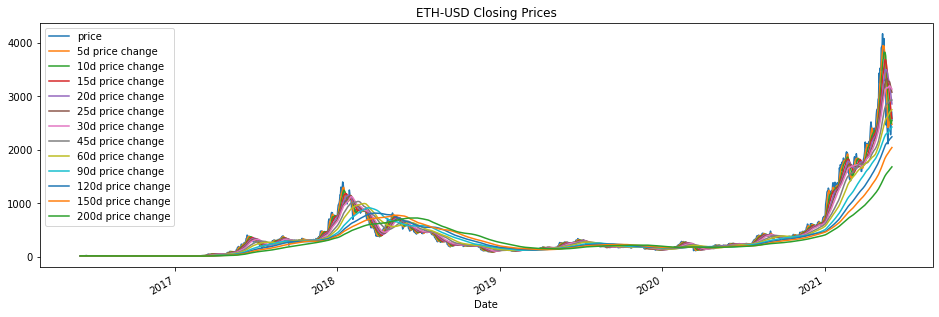

In [13]:
# Regular moving averages
# final_df['Adj Close'].iloc[-313:].plot(label='price',figsize=(16,5),title='ETH-USD Closing Prices')
# final_df['ma1'].iloc[-313:].plot(label='5d price change')
# final_df['ma2'].iloc[-313:].plot(label='10d price change')
# final_df['ma3'].iloc[-313:].plot(label='15d price change')
# final_df['ma4'].iloc[-313:].plot(label='20d price change')
# final_df['ma5'].iloc[-313:].plot(label='25d price change')
# final_df['ma6'].iloc[-313:].plot(label='30d price change')
# final_df['ma7'].iloc[-313:].plot(label='45d price change')
# final_df['ma8'].iloc[-313:].plot(label='60d price change')
# final_df['ma9'].iloc[-313:].plot(label='90d price change')
# final_df['ma10'].iloc[-313:].plot(label='120d price change')
# final_df['ma11'].iloc[-313:].plot(label='150d price change')
# final_df['ma12'].iloc[-313:].plot(label='200d price change')
final_df['Adj Close'].plot(label='price',figsize=(16,5),title='ETH-USD Closing Prices')
final_df['ma1'].plot(label='5d price change')
final_df['ma2'].plot(label='10d price change')
final_df['ma3'].plot(label='15d price change')
final_df['ma4'].plot(label='20d price change')
final_df['ma5'].plot(label='25d price change')
final_df['ma6'].plot(label='30d price change')
final_df['ma7'].plot(label='45d price change')
final_df['ma8'].plot(label='60d price change')
final_df['ma9'].plot(label='90d price change')
final_df['ma10'].plot(label='120d price change')
final_df['ma11'].plot(label='150d price change')
final_df['ma12'].plot(label='200d price change')

plt.legend()

# Loop through the position crossover columns and apply the money made to pick best crossover column

In [14]:

# For I in 1:length of each moving average position columns use the fuction buy_at_first_position_sell_all_reenter_no_additional
    # to get the amount that you would have had at the end then compare which moving average crossover would be the most effective...
    # then 

In [53]:
# Filter for nessecary columns in thed datframe.. 
positionsdf = [col for col in final_df.columns if 'pos' in col] # grabe % change columns
#positionsdf
varppp = positionsdf[1]

In [51]:
varf = final_df[positionsdf]
varz = final_df[["Adj Close","Adj Close_percent_change",]]
finalzz = varz.merge(varf, on='Date', how='left')

#finalzz

In [54]:
varzfe = final_df[["Adj Close","Adj Close_percent_change",varppp]]
varzfe

,Adj Close,Adj Close_percent_change,ma1_ma3_pos
Date,,,
2016-06-02,13.738000,0.000000,0.0
2016-06-03,13.846700,0.007912,0.0
2016-06-04,13.740400,-0.007677,0.0
2016-06-05,13.975000,0.017074,0.0
2016-06-06,13.934100,-0.002927,0.0
...,...,...,...
2021-05-28,2419.906250,-0.115689,0.0
2021-05-29,2279.514160,-0.058016,0.0
2021-05-30,2390.305420,0.048603,0.0


In [ ]:
def buy_at_first_position_sell_all_reenter_no_additional(dff,initial_position):
    additional_capital_incrementally = additional_capital_incrementally
    cash_to_spend = []             # this is how much cash you have invested in now
    returnz = []                   # list of returns
    amount_of_cash_put_in =[]      # amount of cash up in 
    
    initial_position = initial_position 
    varzf = dff[dff.positions == 1].first_valid_index()  # find first time the signal goes off get index
    filtered_df = dff.loc[varzf::,]  # bottom half after first signal..  split the dataframe at first time goes off
    length = len(dff.loc[:varzf,])-1 # get the top half of the dataframe where signal is still all 0 and first crossover hasnt happened
    filtered_df2 = dff.iloc[:length,] # split the dataframe at that index. 

    for i in range(0,len(filtered_df)):
        if i == 0: # if it is the first value of dataframe where we filter to the first crossover as the first row
            returnzvar =(initial_position  * filtered_df.iloc[i][7]) + (initial_position) # multiply the price or adjusted value by the % change and add initial position plus price.. (NOt sure if i should do this??? no multiply for first posotiion??)
            returnz.append(returnzvar)

            cash_to_spend.append(0)
            amount_of_cash_put_in.append(initial_position) # append to cashposition list the initial entry position as first value 


        elif filtered_df.positions[i] == 0:
        # Basically then we take the previous value times tjhe return plus previous value
            returnzvar = (returnz[i-1] * filtered_df.iloc[i][7]) + returnz[i-1] # take last returnz value then multiply it 
            returnz.append(returnzvar)

            cash_to_spend.append(cash_to_spend[i-1])
            amount_of_cash_put_in.append(amount_of_cash_put_in[i-1])

        elif filtered_df.positions[i] == -1:
            #returnval = #(returnz[i-1] * -1)# hold for later with cash append 0 because we sold all 
            returnz.append(0)

            cash_to_spend.append(returnz[i-1]) # append the last value of the growing number that you multiply by return.. 
            amount_of_cash_put_in.append(0)

        elif filtered_df.positions[i] == 1: # if its not the first time the cross over happnes (aka) when we put initial position down
            returnz.append(cash_to_spend[i-1]) # because from -1 to 1 cash to spend has been the last value of returnsz we grab that value

            cash_to_spend.append(0) # Make cash to spend 0 again because we are buying agiain which means take all cash on hand and put it back into the stock. 
            amount_of_cash_put_in.append(cash_to_spend[i-1])

        else:
            continue

    filtered_df['buy_sell_crossover_strat_returnz_no_additional_capital'] = returnz
    final_df = pd.concat([filtered_df2, filtered_df])
    return final_df
    
    

In [ ]:

varz = final_df[["Adj Close","Adj Close_percent_change",]]


In [56]:
for col in finalzz.columns[2:]: # iterate through the columns starting at the second column.... 
    #print(col)
    print(finalzz[["Adj Close","Adj Close_percent_change",col]]) # filter through each of the moving average position columns plust adj close and percent change

              Adj Close  Adj Close_percent_change  ma1_ma2_pos
Date                                                          
2016-06-02    13.738000                  0.000000          0.0
2016-06-03    13.846700                  0.007912          0.0
2016-06-04    13.740400                 -0.007677          0.0
2016-06-05    13.975000                  0.017074          0.0
2016-06-06    13.934100                 -0.002927          0.0
...                 ...                       ...          ...
2021-05-28  2419.906250                 -0.115689          1.0
2021-05-29  2279.514160                 -0.058016          0.0
2021-05-30  2390.305420                  0.048603          0.0
2021-05-31  2714.945312                  0.135815         -1.0
2021-06-01  2560.253662                 -0.056978          0.0

[1822 rows x 3 columns]
              Adj Close  Adj Close_percent_change  ma1_ma3_pos
Date                                                          
2016-06-02    13.738000       